In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#### 1.) 각 장비별 총합데이터 총 예측불량률 나열 

In [2]:
df_engel = pd.read_csv('임시라벨링_결과/maker1_concat.csv',encoding='cp949')
df_jsw = pd.read_csv('임시라벨링_결과/maker2_concat.csv',encoding='cp949')
df_lsm = pd.read_csv('임시라벨링_결과/maker3_concat.csv',encoding='cp949')

In [3]:
df_engel = df_engel.sort_values(by='shotdatetime').reset_index(drop=True)
df_engel = df_engel[df_engel['cluster_trainable']==True].reset_index(drop=True)  
df_engel = df_engel.rename(columns={'shotdatetime':'TimeStamp'})
                                
df_jsw = df_jsw.sort_values(by='shotdatetime').reset_index(drop=True)
df_jsw = df_jsw[df_jsw['cluster_trainable']==True].reset_index(drop=True)
df_jsw = df_jsw.rename(columns={'shotdatetime':'TimeStamp'})
                                
                                
df_lsm = df_lsm.sort_values(by='shotdatetime').reset_index(drop=True)
df_lsm = df_lsm[df_lsm['cluster_trainable']==True].reset_index(drop=True)    
df_lsm = df_lsm.rename(columns={'shotdatetime':'TimeStamp'})

df_engel.shape, df_jsw.shape, df_lsm.shape

((877525, 139), (1430294, 147), (1397172, 219))

In [4]:
df_engel['PassOrFail'].value_counts()

0    874309
1      3216
Name: PassOrFail, dtype: int64

In [5]:
(df_engel['PassOrFail'].value_counts()[1]/len(df_engel))*100

0.3664852853195065

In [6]:
df_lsm['PassOrFail'].value_counts()

0    1389881
1       7291
Name: PassOrFail, dtype: int64

In [7]:
(df_lsm['PassOrFail'].value_counts()[1]/len(df_lsm))*100

0.5218398307438168

In [8]:
df_jsw['PassOrFail'].value_counts()

0    1420516
1       9778
Name: PassOrFail, dtype: int64

In [9]:
(df_jsw['PassOrFail'].value_counts()[1]/len(df_jsw))*100

0.6836356721065739

#### 2.) 데이터 총합 불량률 나열 

In [10]:
df_concat = pd.concat([df_engel,df_jsw,df_lsm],axis=0).sort_values(by='TimeStamp').reset_index(drop=True)

In [11]:
shot_cols = [col for col in df_concat.drop(['shotdata_quality_code'],axis=1).columns if col.split('_')[0] == 'shotdata']
set_cols = [col for col in df_concat.columns if col.split('_')[0] == 'set']

In [12]:
#df_concat[shot_cols] = df_concat[shot_cols].fillna(method='bfill').fillna(method='ffill')
#df_concat[set_cols] = df_concat[set_cols].fillna(method='bfill').fillna(method='ffill')

In [13]:
df_concat.rename(columns={'PassOrFail':'prediction'},inplace=True)

In [14]:
#SABUN - 품목코드
#MECHCD - 설비
#moldNumber - 금형
df_sensing = df_concat[shot_cols+['TimeStamp','SABUN','MECHCD','moldNumber','prediction','ITEMNM','MECHNM','moldName']]
df_setting = df_concat[set_cols + ['TimeStamp']]

In [15]:
final_df = df_concat

In [16]:
final_df['prediction'] = final_df['prediction'].replace({0:1,1:0})

In [17]:
final_df['prediction'].value_counts()

1    3684706
0      20285
Name: prediction, dtype: int64

In [18]:
(final_df['prediction'].value_counts()[0]/ len(final_df))*100

0.5475047037901036

In [19]:
analysis_item_list = final_df.SABUN.unique().tolist()

In [20]:
final_df.prediction = final_df.prediction.astype('int')
df = final_df.copy()
df = df.drop(['shotdata_quality_code'],axis=1)
df.shape

(3704991, 271)

In [21]:
shot_data = [col for col in df.columns if col.split('_')[0] == 'shotdata']
set_cols = [col for col in df.columns if col.split('_')[0] == 'set']

In [22]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

#### 3.) 최적 공정조건 추천용 데이터 구축 & 이후 추론용 MongoDB에 입력
- 각 Facility-Item-Setting 기준 최다생산 & 최소 예측불량률 가졌던 학습정보 순차 나열

In [23]:
agg = {'count':'sum','prediction':'mean'}
recipe_df = pd.DataFrame()
df['count'] = 1
for itemCode in tqdm(analysis_item_list, desc="Per Item Recipe Optimization"):
    semi_df = df[df.SABUN == itemCode]
    if len(semi_df) >=4:
        valid_set_cols = [col for col in set_cols if semi_df[col].notna().all()]
        filtered_df = semi_df[valid_set_cols + ['prediction', 'count']].copy()
        grouped_df = filtered_df.groupby(valid_set_cols).agg(agg).reset_index()
        all_combinations = semi_df[set_cols].drop_duplicates()
        result_recipe = pd.merge(all_combinations, grouped_df, on=valid_set_cols, how='left')
        optimization_min = semi_df[set_cols + shot_data].groupby(valid_set_cols).quantile(0.01).reset_index()
        optimization_max = semi_df[set_cols + shot_data].groupby(valid_set_cols).quantile(0.99).reset_index()
        optimization_mean = semi_df[set_cols + shot_data].groupby(valid_set_cols).mean().reset_index()
        for col in shot_data:
            result_recipe[col+'_min']= optimization_min.get(col, np.nan)
            result_recipe[col+'_max']= optimization_max.get(col, np.nan)
            result_recipe[col+'_mean']= optimization_mean.get(col, np.nan)
        best_recipe = result_recipe[(result_recipe['count'] >=100)&(result_recipe['prediction']<=0.999)].sort_values(by='prediction',ascending=False).head(10)
        best_recipe = best_recipe.rename({'count':'productionCount','prediction':'cleanRate'},axis=1)
        best_recipe['rank'] = range(1,len(best_recipe)+1)
        best_recipe['itemCode'] = itemCode
        best_recipe['MECHCD'] = semi_df.MECHCD.unique()[0] 
        best_recipe['moldNumber'] = semi_df.moldNumber.unique()[0]
        best_recipe['ITEMNM'] = semi_df.ITEMNM.unique()[0]
        best_recipe['moldName'] = semi_df.moldName.unique()[0]
        best_recipe['MECHNM'] = semi_df.MECHNM.unique()[0]
        recipe_df = pd.concat([recipe_df,best_recipe])
    else: continue
        
for MECHCD in tqdm(df['MECHCD'].unique(), desc="Per Machine Recipe Optimization"):
    semi_df = df[df.MECHCD == MECHCD]
    if len(semi_df) >=4:
        valid_set_cols = [col for col in set_cols if semi_df[col].notna().all()]
        filtered_df = semi_df[valid_set_cols + ['prediction', 'count']].copy()
        grouped_df = filtered_df.groupby(valid_set_cols).agg(agg).reset_index()
        all_combinations = semi_df[set_cols].drop_duplicates()
        result_recipe = pd.merge(all_combinations, grouped_df, on=valid_set_cols, how='left')
        optimization_min = semi_df[set_cols + shot_data].groupby(valid_set_cols).quantile(0.01).reset_index()
        optimization_max = semi_df[set_cols + shot_data].groupby(valid_set_cols).quantile(0.999).reset_index()
        optimization_mean = semi_df[set_cols + shot_data].groupby(valid_set_cols).mean().reset_index()
        for col in shot_data:
            result_recipe[col+'_min']= optimization_min.get(col, np.nan)
            result_recipe[col+'_max']= optimization_max.get(col, np.nan)
            result_recipe[col+'_mean']= optimization_mean.get(col, np.nan)
        best_recipe = result_recipe[(result_recipe['count'] >=100)&(result_recipe['prediction']<=0.999)].sort_values(by='prediction',ascending=False).head(10)
        best_recipe = best_recipe.rename({'count':'productionCount','prediction':'cleanRate'},axis=1)
        best_recipe['rank'] = range(1,len(best_recipe)+1)
        best_recipe['itemCode'] = 'total'
        best_recipe['MECHCD'] = semi_df.MECHCD.unique()[0] 
        best_recipe['moldNumber'] = 'total'
        best_recipe['ITEMNM'] = 'total'
        best_recipe['moldName'] = 'total'
        best_recipe['MECHNM'] = 'total'
        recipe_df = pd.concat([recipe_df,best_recipe])
    else: continue

Per Machine Recipe Optimization: 100%|█████████████████████████████████████████████████| 26/26 [01:20<00:00,  3.10s/it]


In [24]:
final_current = [col for col in recipe_df.columns if col.split('_')[0] == 'shotdata']
common_use = ['rank','itemCode','MECHCD','moldNumber','ITEMNM','moldName','MECHNM','cleanRate','productionCount']

recipe = recipe_df[set_cols+common_use]
recipe.rename(columns={'moldNumber':'moldnumber','cleanRate':'cleanrate','productionCount':'productioncount'},inplace=True)

optimization = recipe_df[final_current+common_use]
optimization.rename(columns={'ITEMNM':'ITEMNM '},inplace=True)

recipe.shape  , optimization.shape

((1097, 183), (1097, 123))

<AxesSubplot:xlabel='cleanrate', ylabel='Density'>

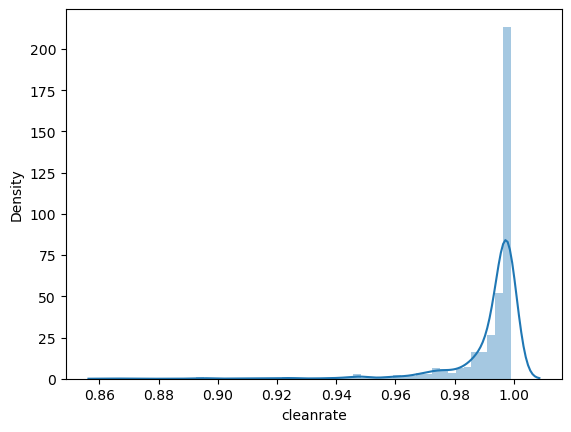

In [25]:
import seaborn as sns
sns.distplot(recipe['cleanrate'])

In [26]:
(195/9500)*100

2.0526315789473686

In [27]:
recipe['cleanrate'].describe()

count    1097.000000
mean        0.992128
std         0.013064
min         0.865979
25%         0.992278
50%         0.996997
75%         0.998265
max         0.998990
Name: cleanrate, dtype: float64

In [28]:
recipe_actual = pd.read_csv('recipe_actual_예시.csv',encoding='cp949').drop(['Unnamed: 0','_id'],axis=1)
recipe_settings = pd.read_csv('recipe_settings_예시.csv',encoding='cp949').drop(['Unnamed: 0','_id'],axis=1)

In [29]:
recipe_settings.shape , recipe_actual.shape

((779, 194), (1000, 120))

In [30]:
missing_cols = [col for col in recipe_actual.columns if col not in optimization.columns]
for col in missing_cols:
    optimization[col] = np.nan
optimization = optimization[recipe_actual.columns].reset_index(drop=True)
optimization['type'] = 'change'

In [31]:
missing_cols = [col for col in recipe_settings.columns if col not in recipe.columns]
for col in missing_cols:
    recipe[col] = np.nan
recipe = recipe[recipe_settings.columns].reset_index(drop=True)
recipe['type'] = 'change'

In [32]:
recipe.shape  , optimization.shape

((1097, 194), (1097, 120))

In [33]:
recipe.to_csv('Recipe_Analysis/recipe_result.csv',encoding='cp949',index=False)
optimization.to_csv('Recipe_Analysis/optimization_result.csv',encoding='cp949',index=False)

In [34]:
recipe

,set_temp_nozzle,set_temp_h1,set_temp_h2,set_temp_h3,set_temp_h4,set_temp_h5,set_temp_h6,set_temp_h7,set_temp_h8,set_weight_rpm1,set_weight_rpm2,set_weight_rpm3,set_weight_rpm4,set_weight_rpm5,set_weight_pos2,set_weight_pos3,set_weight_pos4,set_weight_pos5,set_sucback_pos2,set_close_press,set_close_spd1,set_close_spd2,set_close_spd3,set_close_pos1,set_close_pos2,set_close_pos3,set_open_spd1,set_open_spd2,set_open_spd3,set_open_pos1,set_open_pos2,set_eject_pos,set_eject_forward_spd1,set_eject_forward_spd2,set_eject_forward_press1,set_eject_backward_press1,set_eject_backward_pos1,set_eject_spd1,set_inject_spd1,set_inject_spd2,set_inject_spd3,set_inject_spd4,set_inject_spd5,set_inject_spd6,set_inject_spd7,set_pack_press1,set_pack_press2,set_pack_press3,set_pack_press4,set_pack_press5,set_pack_press6,set_pack_press_time1,set_pack_press_time2,set_pack_press_time3,set_cooling_time,set_inject_pos2,set_inject_pos3,set_inject_pos4,set_inject_pos5,set_inject_pos6,set_inject_pos7,set_inject_max_press,set_backpress_press1,set_backpress_press2,set_backpress_press3,set_backpress_press4,set_backpress_press5,set_short_finish_pos,set_hopper_temp,set_hot_runner1,set_hot_runner2,set_hot_runner3,set_hot_runner4,set_hot_runner5,set_hot_runner6,set_hot_runner7,set_hot_runner8,set_hot_runner9,set_hot_runner10,set_hot_runner11,set_hot_runner12,set_weight_press1,set_weight_press2,set_weight_press3,set_weight_pos1,set_sucback_pos1,set_inject_press1,set_inject_press2,set_inject_press3,set_inject_press4,set_inject_press5,set_inject_press6,set_inject_press7,set_pack_press_spd,set_switch_pos,set_inject_pos1,set_temp_nozzle1_upper,set_temp_nozzle1_lower,set_temp_nozzle2_upper,set_temp_nozzle2_lower,set_temp_h1_upper,set_temp_h1_lower,set_temp_h2_upper,set_temp_h2_lower,set_temp_h3_upper,set_temp_h3_lower,set_temp_h4_upper,set_temp_h4_lower,set_temp_h5_upper,set_temp_h5_lower,set_temp_hopper_upper,set_temp_hopper_lower,set_temp_nozzle3_upper,set_temp_nozzle3_lower,set_pack_press_switch_spd,set_pack_press_switch_press,set_temp_oil,set_close_lowpress_pos,set_close_lowpress,set_close_lowpress_time,set_open_highpress,set_open_pos3,set_eject_forward_pos1,set_eject_forward_pos2,set_eject_forward_press2,set_eject_backward_pos2,set_core_forward_delay_time1,set_core_forward_delay_time2,set_core_forward_delay_time3,set_core_forward_delay_time4,set_core_forward_keep_time1,set_core_forward_keep_time2,set_core_forward_keep_time3,set_core_forward_keep_time4,set_core_forward_spd1,set_core_forward_spd2,set_core_forward_spd3,set_core_forward_spd4,set_core_forward_press1,set_core_forward_press2,set_core_forward_press3,set_core_forward_press4,set_core_backward_delay_time1,set_core_backward_delay_time2,set_core_backward_delay_time3,set_core_backward_delay_time4,set_core_backward_keep_time1,set_core_backward_keep_time2,set_core_backward_keep_time3,set_core_backward_keep_time4,set_core_backward_spd1,set_core_backward_spd2,set_core_backward_spd3,set_core_backward_spd4,set_core_backward_press1,set_core_backward_press2,set_core_backward_press3,set_core_backward_press4,set_backpress_distance1,set_backpress_distance2,set_backpress_distance3,set_screw_back_pos,set_temp_mold_fixed1_upper,set_temp_mold_fixed1_lower,set_temp_mold_moving1_upper,set_temp_mold_moving1_lower,set_temp_mold_fixed2_upper,set_temp_mold_fixed2_lower,set_temp_mold_moving2_upper,set_temp_mold_moving2_lower,set_temp_controller_fixed1_upper,set_temp_controller_fixed1_lower,set_temp_controller_moving1_upper,set_temp_controller_moving1_lower,set_temp_controller_fixed2_upper,set_temp_controller_fixed2_lower,set_temp_controller_moving2_upper,set_temp_controller_moving2_lower,set_temp_oil_upper,set_cushion_distance_upper,set_cushion_distance_lower,productioncount,cleanrate,itemCode,rank,moldnumber,MECHCD,MECHNM,ITEMNM,type,set_tc_s_f,set_tc_s_m,set_tm_s_f,set_tm_s_m
0,230.0,230.0,230.0,225.0,NaN,NaN,NaN,NaN,NaN,44.96,44.96,44.96,0.0,14.99,48.0,240.0,240.0,192.0,3.0,13000.0,30.0,40.0,30.0,1450.0,1400.0,100.0,15.0,40.0,40.0,

In [35]:
optimization

,shotdata_inject_time_min,shotdata_inject_time_max,shotdata_inject_time_mean,shotdata_switch_pos_min,shotdata_switch_pos_max,shotdata_switch_pos_mean,shotdata_cushion_distance_min,shotdata_cushion_distance_max,shotdata_cushion_distance_mean,shotdata_weight_time_min,shotdata_weight_time_max,shotdata_weight_time_mean,shotdata_inject_max_press_min,shotdata_inject_max_press_max,shotdata_inject_max_press_mean,shotdata_close_press_peak_min,shotdata_close_press_peak_max,shotdata_close_press_peak_mean,shotdata_pack_press_min,shotdata_pack_press_max,shotdata_pack_press_mean,shotdata_cooling_time_min,shotdata_cooling_time_max,shotdata_cooling_time_mean,shotdata_temp_mold_fixed1_avg_min,shotdata_temp_mold_fixed1_avg_max,shotdata_temp_mold_fixed1_avg_mean,shotdata_temp_mold_moving1_avg_min,shotdata_temp_mold_moving1_avg_max,shotdata_temp_mold_moving1_avg_mean,shotdata_temp_mold_fixed2_avg_min,shotdata_temp_mold_fixed2_avg_max,shotdata_temp_mold_fixed2_avg_mean,shotdata_temp_mold_moving2_avg_min,shotdata_temp_mold_moving2_avg_max,shotdata_temp_mold_moving2_avg_mean,shotdata_temp_nozzle1_avg_min,shotdata_temp_nozzle1_avg_max,shotdata_temp_nozzle1_avg_mean,shotdata_temp_nozzle2_avg_min,shotdata_temp_nozzle2_avg_max,shotdata_temp_nozzle2_avg_mean,shotdata_temp_h1_avg_min,shotdata_temp_h1_avg_max,shotdata_temp_h1_avg_mean,shotdata_temp_h2_avg_min,shotdata_temp_h2_avg_max,shotdata_temp_h2_avg_mean,shotdata_temp_h3_avg_min,shotdata_temp_h3_avg_max,shotdata_temp_h3_avg_mean,shotdata_temp_h4_avg_min,shotdata_temp_h4_avg_max,shotdata_temp_h4_avg_mean,shotdata_temp_h5_avg_min,shotdata_temp_h5_avg_max,shotdata_temp_h5_avg_mean,shotdata_temp_h6_avg_min,shotdata_temp_h6_avg_max,shotdata_temp_h6_avg_mean,shotdata_temp_hopper_avg_min,shotdata_temp_hopper_avg_max,shotdata_temp_hopper_avg_mean,shotdata_temp_nozzle3_avg_min,shotdata_temp_nozzle3_avg_max,shotdata_temp_nozzle3_avg_mean,shotdata_pack_press_switch_spd_min,shotdata_pack_press_switch_spd_max,shotdata_pack_press_switch_spd_mean,shotdata_pack_press_switch_press_min,shotdata_pack_press_switch_press_max,shotdata_pack_press_switch_press_mean,shotdata_backpress_min,shotdata_backpress_max,shotdata_backpress_mean,shotdata_screw_pos_min,shotdata_screw_pos_max,shotdata_screw_pos_mean,shotdata_inject_start_pos_min,shotdata_inject_start_pos_max,shotdata_inject_start_pos_mean,shotdata_weight_torque_min,shotdata_weight_torque_max,shotdata_weight_torque_mean,shotdata_close_press_min,shotdata_close_press_max,shotdata_close_press_mean,shotdata_mold_open_time_min,shotdata_mold_open_time_max,shotdata_mold_open_time_mean,shotdata_mold_close_time_min,shotdata_mold_close_time_max,shotdata_mold_close_time_mean,shotdata_inject_max_spd_min,shotdata_inject_max_spd_max,shotdata_inject_max_spd_mean,shotdata_temp_controller_fixed1_avg_min,shotdata_temp_controller_fixed1_avg_max,shotdata_temp_controller_fixed1_avg_mean,shotdata_temp_controller_moving1_avg_min,shotdata_temp_controller_moving1_avg_max,shotdata_temp_controller_moving1_avg_mean,shotdata_temp_controller_fixed2_avg_min,shotdata_temp_controller_fixed2_avg_max,shotdata_temp_controller_fixed2_avg_mean,shotdata_temp_controller_moving2_avg_min,shotdata_temp_controller_moving2_avg_max,shotdata_temp_controller_moving2_avg_mean,shotdata_temp_oil_avg_min,shotdata_temp_oil_avg_max,shotdata_temp_oil_avg_mean,productionCount,cleanRate,itemCode,rank,moldNumber,MECHCD,MECHNM,ITEMNM,type
0,2.74,2.80000,2.770114,13.99,17.00000,15.256984,11.8300,14.79000,13.149894,21.3772,25.66410,25.029720,148.6744,155.5364,152.821890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,969,0.998968,W-V802-00031D-A,1,21M0580Z,2022,2-1호기,CELL LWR LONG (사출),change
1,2.71,2.7